In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_ccf # Cross-correlation function

In [2]:
# Manually parse PMI dates (e.g., 'Jun-25' => 2025-06-01)
def parse_excel_months(date_str):
    try:
        return pd.to_datetime(date_str, format="%b-%y")  # 'Jun-25' → 2025-06-01
    except:
        return pd.NaT

# Load PMI data and fix dates
pmi_df = pd.read_csv("data/shanghai-consumer-price-index.csv")
pmi_df.columns = ['date', 'cpi']
pmi_df['date'] = pmi_df['date'].apply(parse_excel_months)
pmi_df = pmi_df.dropna(subset=['date'])
pmi_df = pmi_df.sort_values('date')

# Clean pollution data
def read_and_clean(filepath):
    df = pd.read_csv(filepath)
    df.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])

    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df.sort_values('date')

pollution_df = read_and_clean('data/shanghai.csv')
pollution_df.set_index('date', inplace=True)

pollution_df

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_57481/4030353903.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


,PM25,PM10,O3,NO2,SO2,CO
date,,,,,,
2014-01-01,NaN,121.0,29.0,57.0,30.0,14.0
2014-01-02,188.0,92.0,39.0,54.0,17.0,13.0
2014-01-03,170.0,105.0,21.0,55.0,32.0,12.0
2014-01-04,191.0,94.0,18.0,36.0,19.0,9.0
2014-01-05,176.0,53.0,13.0,37.0,13.0,7.0
...,...,...,...,...,...,...
2025-07-07,51.0,15.0,25.0,4.0,3.0,4.0
2025-07-08,27.0,18.0,20.0,4.0,3.0,4.0
2025-07-09,26.0,21.0,23.0,4.0,3.0,4.0


In [3]:
pollutant='NO2'

In [4]:
# Set PMI index to month-end
pmi_df['date'] = pmi_df['date'] + pd.offsets.MonthEnd(0)
pmi_df.set_index('date', inplace=True)


In [5]:
def read_and_clean(filepath):
    df = pd.read_csv(filepath)
    data = df.copy()
    data.date = pd.to_datetime(data.date)
    data = data.sort_values(by='date', ascending=False)

    data.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

    for col in data.columns:
        if col != "date":
            data[col] = pd.to_numeric(data[col], errors='coerce')

    return data

shh_df = read_and_clean('data/shanghai.csv')
cpi = pd.read_csv('data/shanghai-consumer-price-index.csv')
cpi.columns = ['date','cpi']

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_57481/3018550817.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.date = pd.to_datetime(data.date)


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plotPollutantVsCPI(shh_df, cpi_df, pollutant):
    # Step 1: Fix CPI date format (assumed format 'Jun-25')
    cpi_df = cpi_df.copy()
    cpi_df['date'] = pd.to_datetime(cpi_df['date'], format='%b-%y', errors='coerce')
    cpi_df = cpi_df.dropna(subset=['date'])
    cpi_df['year_month'] = cpi_df['date'].dt.to_period('M').dt.to_timestamp()
    cpi_monthly = cpi_df.groupby('year_month')['cpi'].mean().reset_index()

    # Step 2: Fix pollution dates
    shh_df = shh_df.copy()
    shh_df['date'] = pd.to_datetime(shh_df['date'], errors='coerce')
    shh_df = shh_df.dropna(subset=['date'])
    shh_df['year_month'] = shh_df['date'].dt.to_period('M').dt.to_timestamp()
    shh_df[pollutant] = pd.to_numeric(shh_df[pollutant], errors='coerce')
    pollutant_monthly = shh_df.groupby('year_month')[pollutant].mean().reset_index()

    # Step 3: Merge on year_month
    merged = pd.merge(pollutant_monthly, cpi_monthly, on='year_month', how='inner')

    print(f"Merged shape: {merged.shape}")
    print(f"Merged date range: {merged['year_month'].min()} to {merged['year_month'].max()}")
    if merged.empty:
        print("Still no overlapping dates. Double check formats.")
        return

    # Step 4: Plot
    fig, ax1 = plt.subplots(figsize=(16, 5))

    ax1.set_title(f'Monthly Average {pollutant.upper()} in Shanghai vs CPI', fontsize=14)
    ax1.set_xlabel('Month')
    ax1.plot(merged['year_month'], merged[pollutant], color='tab:blue', label=pollutant)
    ax1.set_ylabel(f'{pollutant} Concentration', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(merged['year_month'], merged['cpi'], color='tab:red', label='CPI')
    ax2.set_ylabel('CPI', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.show()


Merged shape: (113, 3)
Merged date range: 2016-01-01 00:00:00 to 2025-06-01 00:00:00


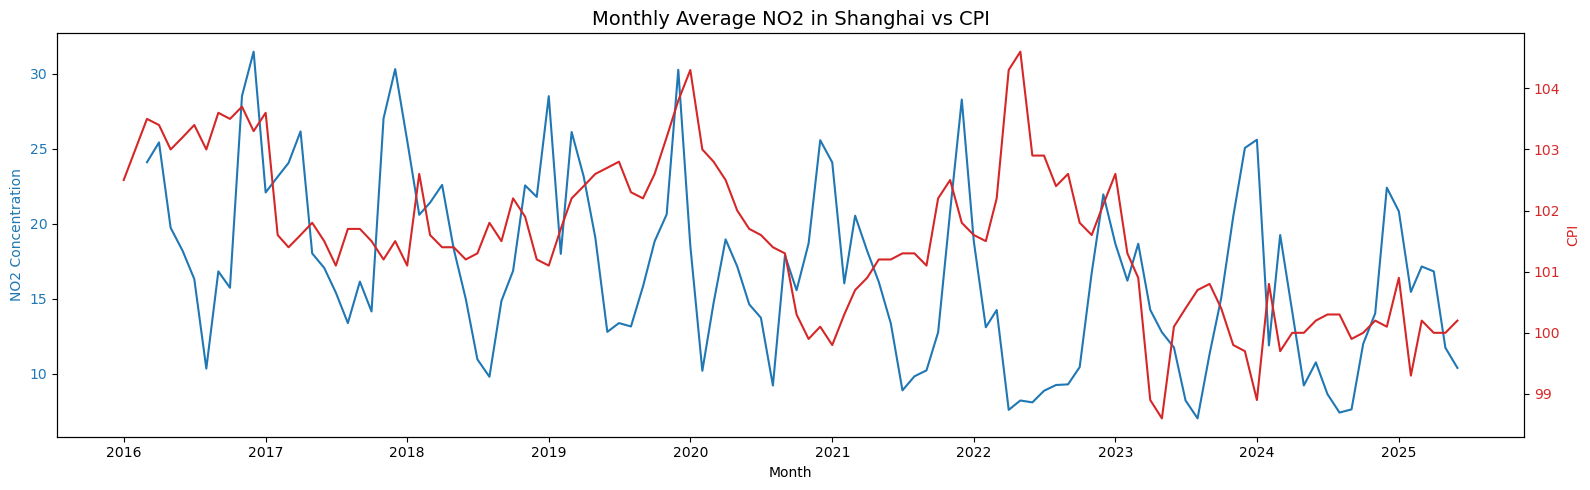

In [7]:
plotPollutantVsCPI(shh_df, cpi, pollutant=pollutant)

In [8]:
# Resample pollution data from daily to monthly mean
monthly_pollution = pollution_df.resample('M').mean()

# Combine with monthly PMI data
monthly_data = monthly_pollution.join(pmi_df, how='inner')

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_57481/311897133.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pollution = pollution_df.resample('M').mean()


In [9]:
monthly_pollution

,PM25,PM10,O3,NO2,SO2,CO
date,,,,,,
2014-01-31,137.666667,68.419355,27.258065,28.806452,14.419355,7.612903
2014-02-28,118.785714,47.250000,31.285714,19.000000,7.892857,5.928571
2014-03-31,127.322581,61.580645,39.612903,27.193548,8.741935,5.548387
2014-04-30,124.866667,55.300000,44.500000,24.566667,5.666667,4.966667
2014-05-31,136.322581,73.225806,65.225806,22.451613,6.322581,5.677419
...,...,...,...,...,...,...
2025-03-31,92.870968,43.225806,43.354839,17.161290,3.580645,5.806452
2025-04-30,100.233333,55.133333,62.566667,16.833333,4.066667,6.300000
2025-05-31,81.645161,39.225806,61.161290,11.741935,3.774194,5.225806


In [10]:
monthly_data

,PM25,PM10,O3,NO2,SO2,CO,cpi
date,,,,,,,
2016-01-31,200.000000,NaN,NaN,NaN,NaN,NaN,102.5
2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN,102.8
2016-03-31,131.176471,60.333333,44.055556,24.111111,8.111111,5.000000,103.5
2016-04-30,127.733333,60.800000,54.033333,25.433333,6.466667,5.633333,103.4
2016-05-31,120.129032,59.903226,56.741935,19.741935,5.419355,6.000000,103.0
...,...,...,...,...,...,...,...
2025-02-28,104.678571,48.607143,31.892857,15.464286,3.500000,6.428571,99.3
2025-03-31,92.870968,43.225806,43.354839,17.161290,3.580645,5.806452,100.2
2025-04-30,100.233333,55.133333,62.566667,16.833333,4.066667,6.300000,100.0


Monthly NO2 is non-stationary. Differencing applied.
CPI is non-stationary. Differencing applied.


<Figure size 1000x600 with 0 Axes>

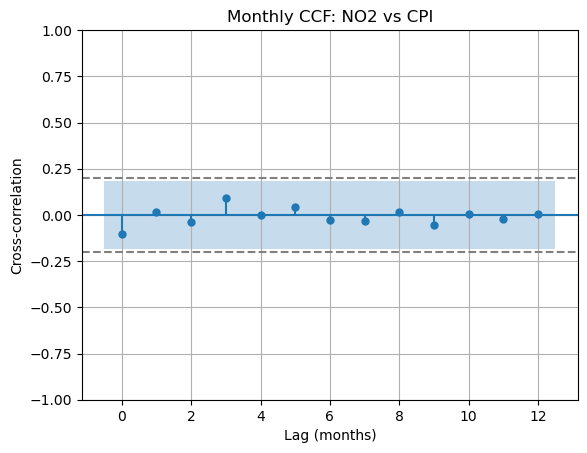

In [11]:
def ccf(pollutant):
    # Check & Enforce Stationarity 
    def make_stationary(series, name):
        result = adfuller(series.dropna())
        if result[1] > 0.05:
            print(f"{name} is non-stationary. Differencing applied.")
            return series.diff().dropna()
        else:
            print(f"{name} is stationary.")
            return series.dropna()

    pollution_diff = make_stationary(monthly_data[pollutant], "Monthly {pollutant}".format(pollutant=pollutant))
    pmi_diff = make_stationary(monthly_data['cpi'], "CPI")

    # Align Differenced Series After Differencing
    aligned = pd.concat([pollution_diff, pmi_diff], axis=1).dropna()

    # Plot CCF
    plt.figure(figsize=(10, 6))
    plot_ccf(aligned[pollutant], aligned['cpi'], lags=12)
    plt.title("Monthly CCF: {pollutant} vs CPI".format(pollutant=pollutant))
    plt.xlabel("Lag (months)")
    plt.ylabel("Cross-correlation")
    plt.axhline(y=0.2, linestyle='--', color='gray')
    plt.axhline(y=-0.2, linestyle='--', color='gray')
    plt.grid(True)
    plt.show()

# for col in pollution_df:
#     ccf(col)

ccf(pollutant)

<Figure size 1000x600 with 0 Axes>

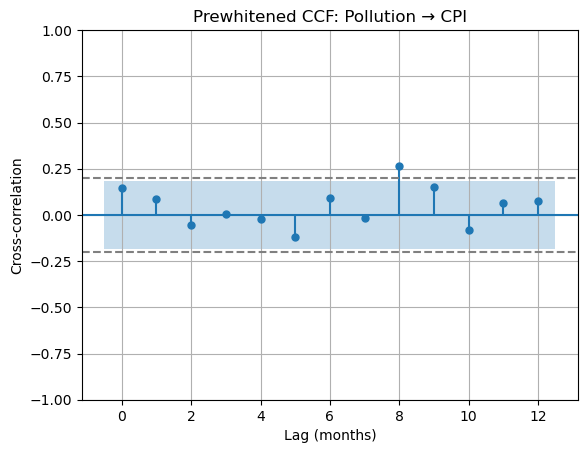

In [12]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf

# Ensure monthly_data has pollution and PMI
def prewhitening(pollutant):
    pollution = monthly_data[pollutant].dropna()
    pmi = monthly_data['cpi'].dropna()

    # Align the series
    data = pd.concat([pollution, pmi], axis=1).dropna()

    # Fit ARIMA model to pollution
    model = ARIMA(data[pollutant], order=(1, 0, 0))  # AR(1) for simplicity; refine this via AIC later
    model_fit = model.fit()

    # Extract residuals (white noise version of pollution)
    pollution_resid = model_fit.resid

    # Get the AR coefficient (phi_1)
    phi = model_fit.arparams[0]

    # Apply the same filter to PMI: x_t - phi * x_{t-1}
    pmi_filtered = data['cpi'].copy()
    pmi_filtered.iloc[1:] = pmi_filtered.iloc[1:] - phi * pmi_filtered.shift(1).iloc[1:]

    # Align residuals and filtered series
    aligned = pd.concat([pollution_resid, pmi_filtered], axis=1).dropna()
    aligned.columns = ['pollution_resid', 'pmi_filtered']

    plt.figure(figsize=(10, 6))
    plot_ccf(aligned['pollution_resid'], aligned['pmi_filtered'], lags=12)
    plt.title("Prewhitened CCF: Pollution → CPI")
    plt.xlabel("Lag (months)")
    plt.ylabel("Cross-correlation")
    plt.grid(True)
    plt.axhline(y=0.2, linestyle='--', color='gray')
    plt.axhline(y=-0.2, linestyle='--', color='gray')
    plt.show()


prewhitening(pollutant)

In [13]:
# GRANGER-CAUSALITY

In [14]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import pandas as pd

def granger_test(pollutant, max_lag=12):
    """
    Perform Granger causality test: Does pollutant Granger-cause PMI?
    """
    # Step 1: Drop NA and extract the relevant columns
    data = monthly_data[[pollutant, 'cpi']].dropna()

    # Step 2: Make both series stationary
    def make_stationary(series):
        result = adfuller(series.dropna())
        if result[1] > 0.05:
            return series.diff().dropna()
        else:
            return series.dropna()
    
    pollution_stationary = make_stationary(data[pollutant])
    pmi_stationary = make_stationary(data['cpi'])

    # Step 3: Align the two differenced series
    aligned = pd.concat([pollution_stationary, pmi_stationary], axis=1).dropna()
    aligned.columns = [pollutant, 'cpi']

    # Step 4: Run Granger causality test
    print(f"\n--- Granger Causality Test: {pollutant} → PMI ---")
    grangercausalitytests(aligned, maxlag=max_lag, verbose=True)

granger_test(pollutant)


--- Granger Causality Test: NO2 → PMI ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0054  , p=0.9413  , df_denom=107, df_num=1
ssr based chi2 test:   chi2=0.0056  , p=0.9404  , df=1
likelihood ratio test: chi2=0.0056  , p=0.9404  , df=1
parameter F test:         F=0.0054  , p=0.9413  , df_denom=107, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1375  , p=0.8717  , df_denom=104, df_num=2
ssr based chi2 test:   chi2=0.2881  , p=0.8658  , df=2
likelihood ratio test: chi2=0.2877  , p=0.8660  , df=2
parameter F test:         F=0.1375  , p=0.8717  , df_denom=104, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3141  , p=0.8152  , df_denom=101, df_num=3
ssr based chi2 test:   chi2=1.0075  , p=0.7994  , df=3
likelihood ratio test: chi2=1.0028  , p=0.8006  , df=3
parameter F test:         F=0.3141  , p=0.8152  , df_denom=101, df_num=3

Granger Causality
number of lags (no zero) 4
ssr b

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag Order Selection:
  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        2.323      2.376*       10.21       2.344
1        2.389       2.546       10.90       2.453
2        2.438       2.700       11.45       2.544
3        2.481       2.848       11.96       2.630
4        2.511       2.983       12.33       2.702
5        2.535       3.112       12.64       2.769
6        2.575       3.256       13.17       2.851
7        2.585       3.371       13.32       2.903
8        2.486       3.377       12.09       2.846
9        2.522       3.518       12.57       2.925
10       2.178       3.279       8.941       2.623
11       1.889       3.095       6.726       2.377
12      1.541*       2.851      4.773*      2.071*
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date: 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


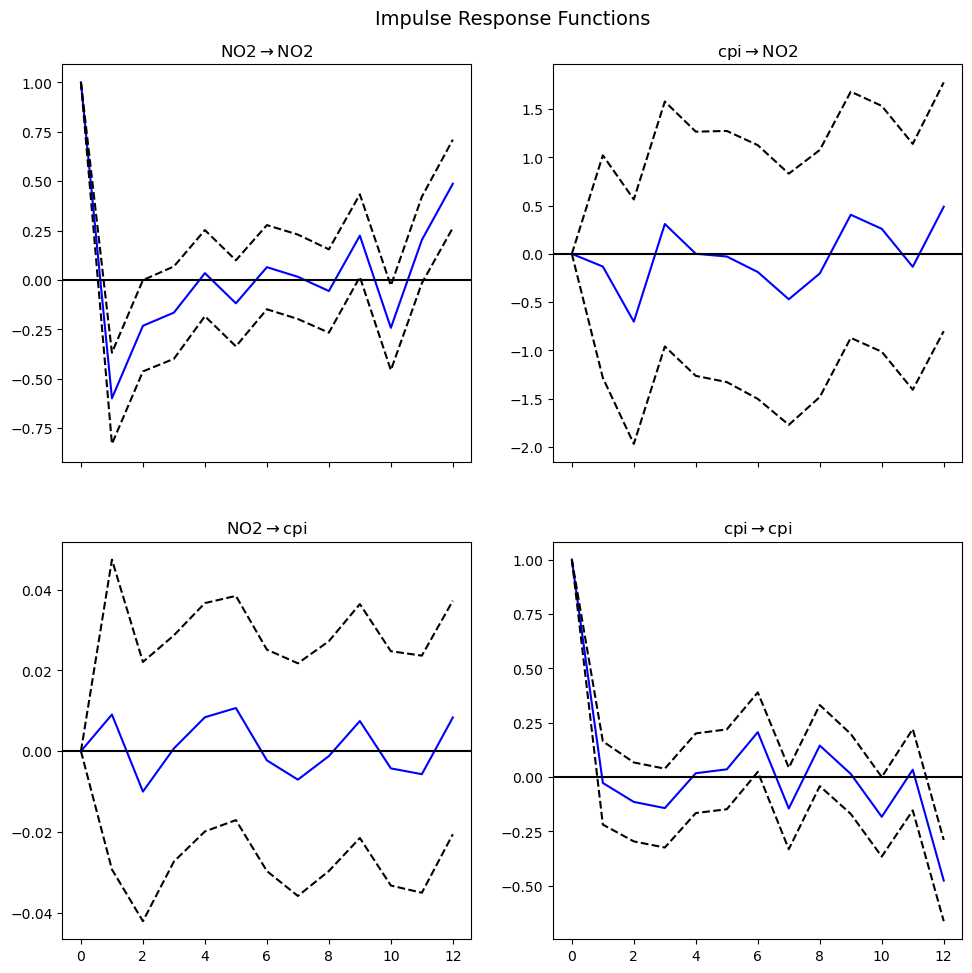

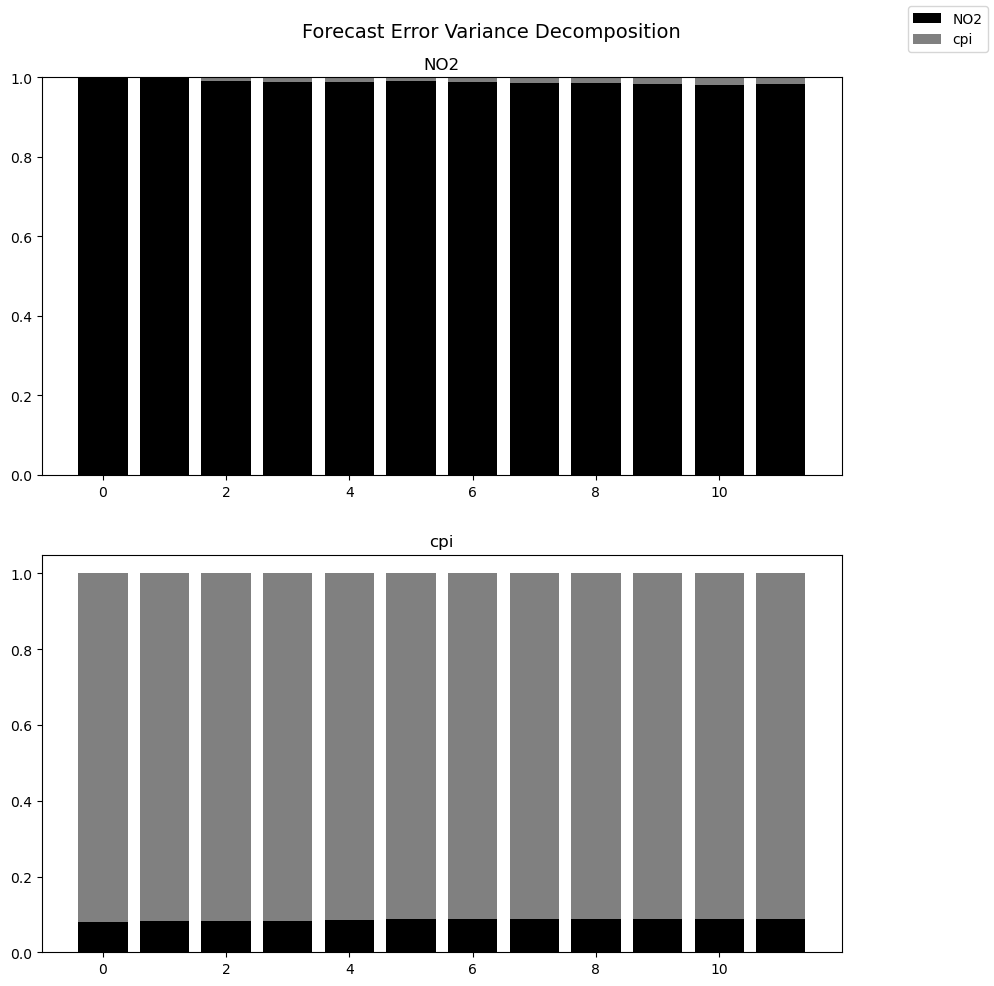

In [15]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Step 1: Ensure Stationarity
def make_stationary(series):
    result = adfuller(series.dropna())
    return series.diff().dropna() if result[1] > 0.05 else series.dropna()

# Prepare and align
data = monthly_data[[pollutant, 'cpi']].dropna()
data[pollutant] = make_stationary(data[pollutant])
data['cpi'] = make_stationary(data['cpi'])
data = data.dropna()

# Step 2: Select optimal lag length
model = VAR(data)
lag_results = model.select_order(12)
print("Lag Order Selection:\n", lag_results.summary())

# Step 3: Fit the VAR model
best_lag = lag_results.selected_orders['aic']  # or use 'bic'
var_model = model.fit(best_lag)
print(var_model.summary())

# Step 4: Impulse Response Function
irf = var_model.irf(12)  # 12 months horizon
irf.plot(orth=False)
plt.suptitle("Impulse Response Functions", fontsize=14)
plt.show()

# Step 5: Forecast Error Variance Decomposition
fevd = var_model.fevd(12)
fevd.plot()
plt.suptitle("Forecast Error Variance Decomposition", fontsize=14)
plt.show()